# Deep Learning Lab: EE-045107
## Meeting 4: Denoising Diffusion Probabilistic Models
## Part I: Toy example

Before running the code in this file, make sure that you are **activating the enviourment** in which the following packages are installed.

### Importing relevant libraries

In [1]:
## Standard libraries
import numpy as np
import math

## Progress bar
import tqdm.notebook as tqdm

## Imports for plotting
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
plt.style.use('ggplot')

## Scikit-learn built-in dataset generators
from sklearn.datasets import make_moons, make_circles, make_blobs, make_swiss_roll

## Pytorch
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# device to be used
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Using device", device)

Using device cuda:0


In [3]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.half_dim = self.dim // 2
        self.max_freq = math.log(10000) / (self.half_dim - 1)
        self.freqs = torch.exp(torch.arange(self.half_dim) * -self.max_freq)

    def forward(self, time):
        embeddings = self.freqs.to(time.device)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.stack((embeddings.cos(), embeddings.sin()), dim=-1).view(-1,self.dim)
        return embeddings

## Toy 2D implementation

In this part we will implement denoising diffusion models and apply them to multiple toy 2D datasets. For your convenience, the provided function `sample_2d_datasets` samples from 3 different toy datasets that we will use for this part. The supported options in this function are `{'Spiral', 'Circles', 'Moons'}`.

In [4]:
def sample_2d_datasets(dist_type, num_samples=1000, seed=0):
  """
  function samples from simple pre-defined distributions in 2D.
  Inputs:
    - dist_type: str specifying the distribution to be chosen from:
      {'Spiral', Circles', 'Moons'}
    - num_samples: Number of samples to draw from dist_type (int).
    - seed: Random seed integer.
  Outputs:
    - data (np.array): array of num_samplesx2 samples from dist_type
  """
  np.random.seed(seed)
  if dist_type == 'Spiral':
    data = make_swiss_roll(num_samples, noise=0.0, random_state=seed)[0]
    data = data[:,[0,2]]
  elif dist_type == 'Circles':
    data = make_circles(num_samples, noise=0.01, factor=0.5, random_state=seed, shuffle=True)[0]
  elif dist_type == 'Moons':
    data = make_moons(num_samples, noise=.01, random_state=seed, shuffle=True)[0]
  else:
    raise NotImplementedError
  data = 2.*(data - data.min(axis=0))/(data.max(axis=0) - data.min(axis=0)) - 1.
  return data

Use 'sample_2d_datasets' function for each of the 3 distributions above: draw $N = 1000$ samples $\{\mathbf{x}_i\}$.
Display the drawn samples for each distribution in a separate plot using scatter plot.

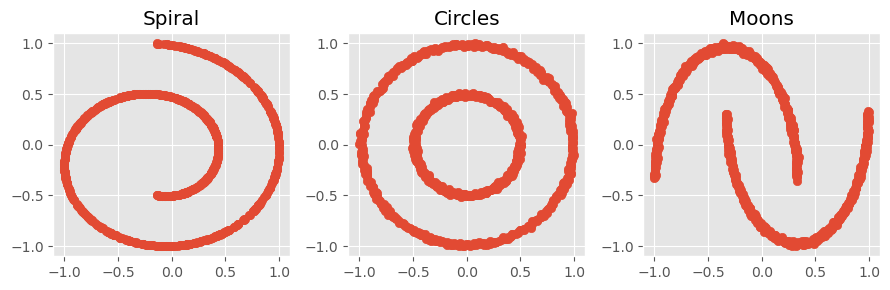

In [5]:
plt.figure(figsize=(9, 3))

# Spiral
data = sample_2d_datasets('Spiral', num_samples=1000)
plt.subplot(1, 3, 1)
plt.scatter(data[:,0], data[:,1])
plt.title('Spiral')

# Circles
data = sample_2d_datasets('Circles', num_samples=1000)
plt.subplot(1, 3, 2)
plt.scatter(data[:,0], data[:,1])
plt.title('Circles')

# Moons
data = sample_2d_datasets('Moons', num_samples=1000)
plt.subplot(1, 3, 3)
plt.scatter(data[:,0], data[:,1])
plt.title('Moons')

plt.tight_layout()
plt.show()

In this part of the lab, we will use a simple fully-connected architecture with each block `MlpBlock` conditioned on both $x_t$ and $t$ as follows:

In [6]:
# basic building block for time-conditional MLP
class MlpBlock(nn.Module):
    def __init__(self, dim_in=32, dim_out=32, dim_t=32):
        super(MlpBlock, self).__init__()
        self.x_mlp = nn.Sequential(nn.Linear(dim_in, dim_out), nn.SiLU())
        self.t_mlp = nn.Sequential(nn.Linear(dim_t, dim_out))
        self.silu = nn.SiLU()
        
    def forward(self, x, t):
        x = self.x_mlp(x)
        t = self.t_mlp(t)
        return self.silu(x + t)

The overall architecture $\mathbf{\epsilon}_{\theta}(\mathbf{x}_t,t)$, first encodes $t$ using the sinusoidal positional encoding technique and then uses several `MlpBlock` layers as follows:

In [7]:
class NoiseModel(nn.Module):
    def __init__(self, dim_hid=256, dim_t=256):
        super(NoiseModel, self).__init__()
        self.pos_enc = SinusoidalPositionEmbeddings(dim_t)
        self.layer_t = nn.Sequential(nn.Linear(dim_t, dim_hid), 
                                     nn.SiLU(), 
                                     nn.Linear(dim_hid, dim_hid), 
                                     nn.SiLU())
        self.layer1 = MlpBlock(dim_in=2, dim_out=dim_hid, dim_t=dim_t)
        self.layer2 = MlpBlock(dim_in=dim_hid, dim_out=dim_hid, dim_t=dim_t)
        self.layer3 = MlpBlock(dim_in=dim_hid, dim_out=dim_hid, dim_t=dim_t)
        self.layer_out = nn.Linear(dim_hid, 2)

    def forward(self, x, t):
        
        # time embedding
        t = self.pos_enc(t)
        t = self.layer_t(t)
        
        # time-conditional layers
        x = self.layer1(x, t)
        x = self.layer2(x, t)
        x = self.layer3(x, t)
        x = self.layer_out(x)
        return x

#### Diffusion Model - Preparation

In [8]:
standardT_flag = False

# ask the instructor which distribution type to use!
our_dist_type = 'Spiral'
if standardT_flag:
    T = 40
else:
    T = 10

For your conveience we pre-calculated all the constants you're gonna need during forward and reverse diffusion:
* `self.sigmas` - the standard deviations of $p_{\theta}(\mathbf{x}_{t-1}\lvert\mathbf{x}_t)$ assuming $\Sigma_{\theta}(\mathbf{x}_t,t)=\sigma_t^2\mathbf{I}=\beta_t\mathbf{I}$.
* `self.alphas` and `self.alphas_bar` - $\alpha_t=1-\beta_t$ and $\bar{\alpha}_t=\prod_{s=1}^t\alpha_s$ respectively.
* `self.sqrt_alphas_bar` and `sqrt_1_minus_alphas_bar` - $\sqrt{\bar{\alpha}_t}$ and $\sqrt{1-\bar{\alpha}_t}$.
* `self.inv_sqrt_alphas`, `self.inv_sqrt_alphas_bar`, and `self.pre_noise_terms` - $\frac{1}{\sqrt{\alpha_t}}$, $\frac{1}{\sqrt{\bar{\alpha}_t}}$, and $\frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}$.

Also, this class holds some initiation parameters, such as $T$, the number of diffusion time-steps.

In [9]:
class DiffusionModelConstants:
    def __init__(self, T, beta1, betaT):
        
        # basic properties
        self.T = T
        self.betas = torch.linspace(beta1, betaT, self.T).to(device)
        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, axis=0)
        self.sigmas = torch.pow(self.betas, 0.5)

        # pre-calculations of useful terms
        self.sqrt_alphas_bar = torch.sqrt(self.alphas_bar)
        self.sqrt_1_minus_alphas_bar = torch.sqrt(1 - self.alphas_bar)
        self.inv_sqrt_alphas = torch.pow(self.alphas, -0.5)
        self.inv_sqrt_alphas_bar = torch.pow(self.alphas_bar, -0.5)
        self.pre_noise_terms = self.betas / self.sqrt_1_minus_alphas_bar

Let us refresh our memory regarding the dimensions of these constants using an example

In [10]:
diffusion_consts = DiffusionModelConstants(T=T, beta1=0.0002, betaT=0.00225)

# The dimensions of the useful constants
print(f"The length of sigma array: {len(diffusion_consts.sigmas)}")

if standardT_flag:
    # How to use (remember to start the counting from zero):
    print(f"Let's see the value of the 3rd element in the Sigma sequence: {diffusion_consts.sigmas[2]}")
    print(f"Let's see the value of the 40th element in the Sigma sequence: {diffusion_consts.sigmas[39]}")

The length of sigma array: 10


#### Forward diffusion

Complete the code of the method `diffuse`, which diffuses $\mathbf{x}_0$ for $t$ steps according to $q(\mathbf{x}_t|\mathbf{x}_0)$.  
This function accepts four inputs:
 * `x0` - the current batch of $B \times 2$ training samples $\mathbf{x}_0$.
 * `t` - $B \times 1$ tensor indicating the used timesteps $t$ corresponding to each sample in the batch.
 * `diffusion_consts` - an instance of the class DiffusionModelConstants, which holds the pre-calculated constants.
 * `device` - torch device.


In [11]:
def diffuse(x0, t, diff_constants, device):    
    # draw random gaussian noise in the size and shape of the original data
    eps = torch.randn(size=x0.shape).to(device)
    # use the pre-calculated constants to calculate xt based on x0 and eps
    xt = diff_constants.sqrt_alphas_bar[t-1]*x0+diff_constants.sqrt_1_minus_alphas_bar[t-1]*eps
    return eps, xt

Use the following code section to present the 'forward diffusion' process, and to verify that it works correctly.

In [12]:
# Draw dataset of x0 samples
data = sample_2d_datasets(our_dist_type, num_samples=100000)
x0 = torch.Tensor(data).to(device)
print(x0.shape)
if standardT_flag:
    t_example_values = [1, 7, 10, 20, 30]
    plt.figure(figsize=(25,len(t_example_values)))
    for i, t in enumerate(t_example_values,1):
        time_index = torch.LongTensor([t]).to(device)

        plt.subplot(1,5,i)
        _, diffused = diffuse(x0,t,diffusion_consts,device)
        plt.scatter(diffused[:,0].cpu().numpy(), diffused[:,1].cpu().numpy())
        plt.title(f'$x_{{{t}}}$')
    plt.show() 

torch.Size([100000, 2])


#### Training loss
Implement the loss function $L_{\text{simple}}(\theta)$.  
This function uses the 'diffuse()' function and 'eps_model' instance for calculating 'eps' and 'predicted_eps'.  
The function accepts four inputs:
 * `x0` - the current batch of $B \times 2$ training samples $\mathbf{x}_0$.
 * `t` - $B \times 1$ tensor indicating the used timesteps $t$ corresponding to each sample in the batch.
 * `diffusion_consts` - an instance of the class DiffusionModelConstants, which holds the pre-calculated constants.
 * `eps_model` - an instance of the class NoiseModel, which holds the MLP network that predicts noise.

We shall use it later along the training steps from Algorithm 1.

In [13]:
def calc_loss(x0, t, diff_constants, eps_model, device): 
    # calculate eps and predicted_eps
    eps, xt = diffuse(x0,t,diff_constants,device)
    predicted_eps = eps_model(xt,t)
    # calculate loss
    err = (eps-predicted_eps)**2
    loss = torch.mean(err)
    return loss

#### Training

For your convience, below is a training function `train` using the 'calc_loss' function, that you just implemented.   
This function accepts the following inputs:
* `data` - a $N\times 2$ dataset of samples $\mathbf{x}_0\sim q(\mathbf{x}_0)$.
* `batch_size, num_epochs` - the batch size for training (default 1000) and the number of training epochs (default 50).
* `T, beta1, betaT`- the number of diffusion steps $T$, and $\beta_1$,$\beta_T$ (defaults 2e-4, 2.25e-3) controlling the variance scheduler.
* `device` - device to train on.

After training is done (~roughly 1 minute on a standard GPU), the function returns a `NoiseModel` instance in `eps_model`, and a list of training losses `all_losses` for sanity check.

In [14]:
def train_all(data, batch_size, num_epochs, T, beta1, betaT, device):
    
    # dataset and dataloader
    my_dataset = TensorDataset(torch.Tensor(data))
    my_dataloader = DataLoader(my_dataset, batch_size=batch_size)
    
    # noise model and diffuser class
    eps_model = NoiseModel().to(device)
    diffusion_consts = DiffusionModelConstants(T, beta1, betaT)
    eps_model.train()

    # optimizer
    optimizer = torch.optim.Adam(eps_model.parameters(), lr=0.001)

    # train
    all_losses = []
    with tqdm.tqdm(range(num_epochs), unit=' Epoch') as tepoch:
        for epoch in tepoch:
            for batch in my_dataloader:
            
                # batch of x0 and random ts
                x0 = batch[0].to(device)
                t = torch.randint(1, T+1, (len(x0),)).unsqueeze(1).to(device)

                # calculate loss
                loss = calc_loss(x0, t, diffusion_consts, eps_model, device)

                # backprop
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # record all losses for sanity check
                loss_step = loss.detach().item()
            all_losses.append(loss_step)
            
            # report progress with tqdm pbar
            tepoch.set_postfix(train_loss=loss_step)
    return eps_model, diffusion_consts, all_losses

Train a diffusion model using the provided function `train` with `data` being the samples you created earlier.  
For sanity check, plot the training loss progression in `all_losses`.

  0%|          | 0/50 [00:00<?, ? Epoch/s]

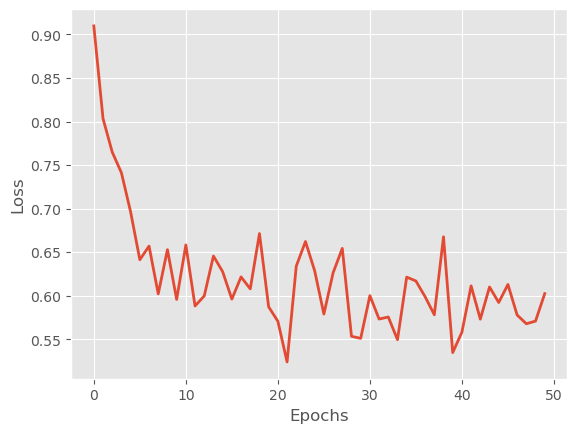

In [15]:
# TODO: Complete the sanity check
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

eps_model, diffusion_consts, all_losses = train_all(data,1024,50,40,0.0002,0.00225,device)
t= range(50)

plt.figure()
plt.plot(t,all_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show() 


#### Reverse diffusion

Complete the code of the method `denoise`, which applies reverse-diffusion on an array of noise samples.  
This function accepts two inputs:
 * `xt` - a batch of $B\times 2$ noisy samples $\mathbf{x}_t$.
 * `T` - the total duration of the requested reverse-diffusion process.

The returned results are:
* `x0` a batch of $B \times 2$ denoised samples $\mathbf{x}_0$ from $p_{\theta}(\mathbf{x}_0\lvert\mathbf{x}_t)$.
* `all_epst` a list of `t` batches of $B\times 2$ predicted noises $\mathbf{\epsilon}_{\theta}(\mathbf{x}_t,t)$ along the trajectory $\mathbf{x}_t\rightarrow\mathbf{x}_0$.
* `all_xt` a list of `t+1` batches of $B \times 2$ denoised samples $\mathbf{x}_{t-1}$ along the trajectory $\mathbf{x}_t\rightarrow\mathbf{x}_0$ including the starting point.
* `all_x0t` a list of `t` batches of $B \times 2$ estimates of $\hat{\mathbf{x}}_0^t$ along the trajectory $\mathbf{x}_t\rightarrow\mathbf{x}_0$.  
**Note: the last output is not part of the algorithm, we calculate it only for learning purpose.**

In [16]:
def denoise(xT, T, diffusion_constants, eps_model, device):
    
    # number of samples in batch
    n_samples = 1 if len(xT.shape) > 1 else xT.shape[0]

    all_xt, all_x0_t, all_eps_t = [xT], [], []
    xt = xT
    # complete the loop code. 
    # Hint: in which order should the index t run? :-)
    for t in range(T, 0, -1):
        if t==1:
                z = torch.zeros(size=xt.shape).to(device)
        else:
                z = torch.randn(size=xt.shape).to(device)
        # create a vector of the current time-step, will be used for all the batch samples
        timesteps = (t * torch.ones(n_samples, device=device, dtype=torch.int)).unsqueeze(1)

        # use the class's noise model to get noise predictions for all xt's in the batch
        eps_t = eps_model(xt,timesteps)

        # calculate x(t-1) based on x(t) and z
        xt_m_1 = diffusion_constants.inv_sqrt_alphas[t-1]*(xt-eps_t*(1-diffusion_constants.alphas[t-1])/diffusion_constants.sqrt_1_minus_alphas_bar[t-1])
        +diffusion_constants.sigmas[t-1]*z

        # ** Just for visualizing the denoising process:***
        # estimate x0^t based on xt and eps_t (remember to use the relevant ARRAYS of multiplier constants)
        x0_t = diffusion_constants.inv_sqrt_alphas_bar[t-1]*(xt-diffusion_constants.sqrt_1_minus_alphas_bar[t-1]*eps_t)

        xt = xt_m_1 # store for next time iteration
        # recording trajectory
        all_eps_t.append(eps_t.detach())
        all_x0_t.append(x0_t.detach())
        all_xt.append(xt.detach())

    # final sample from p(x0|xt)
    x0 = xt
    return x0, all_eps_t, all_xt, all_x0_t

Use the following code section to present the 'reverse diffusion' process, and to verify that it works correctly.

10


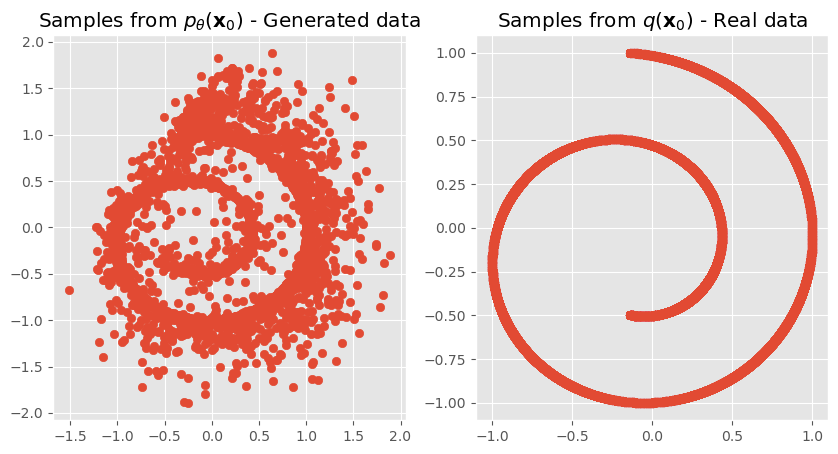

In [17]:
eps_model.eval()
with torch.no_grad():
    # call the 'denoise' function
    x0, all_eps_t, all_xt, all_x0t =denoise(torch.randn(5000,2).to(device), T, diffusion_consts, eps_model, device)

# Plot the samples
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(x0[:,0].cpu().numpy(), x0[:,1].cpu().numpy()) #&sol&
plt.title(r'Samples from $p_{\theta}(\mathbf{x}_0)$ - Generated data')
plt.subplot(1,2,2)
plt.scatter(data[:,0], data[:,1]) #&sol&
plt.title(r'Samples from $q(\mathbf{x}_0)$ - Real data')
print(T)

#### Sampling
The `denoise` function additionally returns intermediate outputs along the trajectory $\mathbf{x}_T\rightarrow\mathbf{x}_0$. Lets watch these vectors and see how the evolve along the time-line.


In [18]:
if standardT_flag:
    # We use 't_example_values' defined previously for the visualization
    # --- Figure 1: x0^t ---
    fig1, axes1 = plt.subplots(1, len(t_example_values), figsize=(20, 4), sharex=True, sharey=True)

    for i, t in enumerate(reversed(t_example_values)):
        arr = all_x0t[T - t].cpu().numpy()
        axes1[i].scatter(arr[:, 0], arr[:, 1], s=8)
        axes1[i].set_title(r'$x_0^t$' + fr' at $t={t}$')
        axes1[i].set_xlim(-1.5, 1.5)
        axes1[i].set_ylim(-1.5, 1.5)
        axes1[i].set_aspect('equal')

    fig1.tight_layout(); plt.show()

    # --- Figure 2: x_{t-1} ---
    fig2, axes2 = plt.subplots(1, len(t_example_values), figsize=(20, 4), sharex=True, sharey=True)

    for i, t in enumerate(reversed(t_example_values)):
        arr = all_xt[T - t + 1].cpu().numpy()
        axes2[i].scatter(arr[:, 0], arr[:, 1], s=8)
        axes2[i].set_title(r'$x_{t-1}$' + fr' at $t={t}$')
        axes2[i].set_xlim(-1.5, 1.5)
        axes2[i].set_ylim(-1.5, 1.5)
        axes2[i].set_aspect('equal')

    fig2.tight_layout(); plt.show()

#### Let's try out one more thing... :-)

Repeat the training and sampling, but this time using a much smaller T value.
We used T=40 before. Now we'll try T=2.

### Conclusion

To conclude, in this part we have seen denoising diffusion models, the current leading generative model in many of the recent technological advancements such as [DALLE](https://openai.com/dall-e-2) and [Imagen](https://imagen.research.google/). As mentioned in the beginning of this part, similar models (much deeper + tricks) are currently leading to state-of-the-art performance in image synthesis, and recently also in solving linear inverse problems. For those of you interested in playing with such models, a lot of great resources are publicly available online, for example [this tutorial](https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing) by [Yang Song](https://yang-song.github.io/) who is the author of some key papers in this field. Another great resource is the [Annotated Diffusion Model](https://huggingface.co/blog/annotated-diffusion) provided by Hugging Face.

### References

[1] Sohl-Dickstein, J., et al., "Deep Unsupervised Learning using Nonequilibrium Thermodynamics", ICML (2015) [Link](http://proceedings.mlr.press/v37/sohl-dickstein15.pdf)

[2] Ho, J., et al., "Denoising Diffusion Probabilistic Models", NeuroIPS (2020) [Link](https://proceedings.neurips.cc/paper_files/paper/2020/file/4c5bcfec8584af0d967f1ab10179ca4b-Paper.pdf)

[3] Song, Y., et al. "Score-based generative modeling through stochastic differential equations", ICLR (2021). [Link](https://arxiv.org/pdf/2011.13456)

[4] Sinai, L. et al. "Denoising diffusion probabilistic models from first principles", Blog post (2022). [Link](https://liorsinai.github.io/coding/2022/12/03/denoising-diffusion-1-spiral.html#denoising-diffusion-probabilistic-models)